# Shallow Water Bathymetry <a id="top"></a>
### Visualizing Differences in Depth With Spectral Analysis
<hr>

# Notebook Summary

* Import data from LANDSAT 8 that has been S3 indexed into the Data Cube database
* A bathymetry index is calculated
* Contrast is adjusted to make a more interpretable visualization.
>Citation: [Stumpf, Richard P., Kristine Holderied, and Mark Sinclair. "Determination of water depth with high‐resolution satellite imagery over variable bottom types." Limnology and Oceanography 48.1part2 (2003): 547-556.](https://www.slideshare.net/fernandojeffersonprudencioparedes/stumpf-et-al-2003)
<hr>

# Algorithmic process  

* [Import Dependencies and Connect to the Data Cube](#import)
* [Choose the Platform and Product](#plat_prod)
* [Define the Extents of the Analysis](#define_extents)
* [Retrieve the Data](#retrieve_data)
* [Calculate the Bathymetry and NDWI Indices](#bathymetry)
* [Export Unmasked GeoTIFF](#export_unmasked)
* [Mask the Dataset Using the Quality Column and NDWI](#mask)
* [Create a Visualization Function](#vis_func)
* [Visualize the Bathymetry](#bath_vis)
* [Visualize the Bathymetry With Adjusted Contrast](#bath_vis_better)
* [Export the Masked GeoTIFF](#export_masked)


<hr>

# How It Works

Bathymetry is the measurement of depth in bodies of water(Oceans, Seas or Lakes).  This notebook illustrates a technique for deriving depth of shallow water areas using purely optical features from Landsat Collection 1 imagery and draws heavily from the publication [Determination of water depth with high-resolution satelite imagery over variable bottom types](https://www.slideshare.net/fernandojeffersonprudencioparedes/stumpf-et-al-2003).

<br>

**Bathymetry Index**  
  
This bathymetry index uses optical `green` and `blue` values on a logarithmic scale with two tunable coefficients `m0` and `m1`.
  

$$ BATH =  m_0*\frac{ln(blue)}{ln(green)} -m_1$$  

Where: 
- `m0` is a tunable scaling factor to tune the ratio to depth <br>
- `m1` is the offset for a depth of 0 meters.

<br>
<div class="alert-info"><br>
<b>Note: </b> that for our purposes, $m_0$ and $m_1$ are equal to <b>1</b> and <b>0</b> respectively, since we cannot determine the baseline nor the offset from spectral reflectance alone. This effectively simplifies the formula to: $$\frac{ln(blue)}{ln(green)}$$
<br>

</div>


#### Bathymetry Index Function

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

def bathymetry_index(df, m0 = 1, m1 = 0):
    return m0*(np.log(df.blue)/np.log(df.green))+m1

## <span id="import">Import Dependencies and Connect to the Data Cube</span>  [&#9652;](#top)

In [2]:
import datacube
dc = datacube.Datacube()

/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/psycopg2-2.7.5-py3.5-linux-x86_64.egg/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


## <span id="plat_prod">Choose the Platform and Product</span>  [&#9652;](#top)

In [3]:
#List the products available on this server/device
dc.list_products()

,name,description,time,lat,platform,format,lon,product_type,instrument,label,creation_time,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,
3,ls5_level1_usgs,Landsat 5 USGS Level 1 Collection-1 OLI-TIRS,None,None,LANDSAT_5,GeoTiff,None,L1TP,TM,None,None,NaN,NaN,NaN,NaN
2,ls7_level1_usgs,Landsat 7 USGS Level 1 Collection-1 OLI-TIRS,None,None,LANDSAT_7,GeoTiff,None,L1TP,ETM,None,None,NaN,NaN,NaN,NaN
4,ls8_l1_pc_usgs,Landsat 8 USGS Level 1 Pre-Collection OLI-TIRS,None,None,LANDSAT_8,GeoTiff,None,L1T,OLI_TIRS,None,None,NaN,NaN,NaN,NaN
1,ls8_level1_usgs,Landsat 8 USGS Level 1 Collection-1 OLI-TIRS,None,None,LANDSAT_8,GeoTiff,None,L1TP,OLI_TIRS,None,None,NaN,NaN,NaN,NaN


In [4]:
#create a list of the desired platforms
platform = "LANDSAT_8"
product = "ls8_level1_usgs"

## <span id="define_extents">Define the Extents of the Analysis</span>  [&#9652;](#top)

### Region bounds

In [5]:
# East Coast of Australia
lat_subsect = (-31.7, -32.2)
lon_subsect = (152.4, 152.9)

In [6]:
print('''
Latitude:\t{0}\t\tRange:\t{2} degrees
Longitude:\t{1}\t\tRange:\t{3} degrees
'''.format(lat_subsect,
           lon_subsect,
           max(lat_subsect)-min(lat_subsect),
           max(lon_subsect)-min(lon_subsect)))


Latitude:	(-31.7, -32.2)		Range:	0.5000000000000036 degrees
Longitude:	(152.4, 152.9)		Range:	0.5 degrees



### Display

In [7]:
from utils.data_cube_utilities.dc_display_map import display_map      
display_map(latitude = lat_subsect,longitude = lon_subsect)

## <span id="retrieve_data">Retrieve the Data</span> [&#9652;](#top)

#### Load and integrate datasets

In [8]:
%%time
ds = dc.load(lat = lat_subsect,
             lon = lon_subsect,
             platform = platform,
             product = product,
             output_crs = "EPSG:32756",
             measurements = ["red","blue","green","nir","quality"],
             resolution = (-30,30))

CPU times: user 2min 37s, sys: 4.24 s, total: 2min 41s
Wall time: 2min 54s


In [9]:
ds

<xarray.Dataset>
Dimensions:  (time: 35, x: 1582, y: 1854)
Coordinates:
  * time     (time) datetime64[ns] 2017-03-05T23:43:08.071085 ...
  * y        (y) float64 6.493e+06 6.493e+06 6.493e+06 6.493e+06 6.493e+06 ...
  * x        (x) float64 4.431e+05 4.432e+05 4.432e+05 4.432e+05 4.433e+05 ...
Data variables:
    red      (time, y, x) int16 7409 7219 7057 6992 6681 7265 7716 7667 7578 ...
    blue     (time, y, x) int16 9152 8963 8867 8880 8634 8994 9315 9425 9391 ...
    green    (time, y, x) int16 8633 8379 8257 8171 7692 8250 8748 8765 8576 ...
    nir      (time, y, x) int16 20952 18379 17023 15962 13921 16725 18606 ...
    quality  (time, y, x) int16 2720 2720 2720 2720 2720 2720 2720 2720 2720 ...
Attributes:
    crs:      EPSG:32756

#### Preview the Data

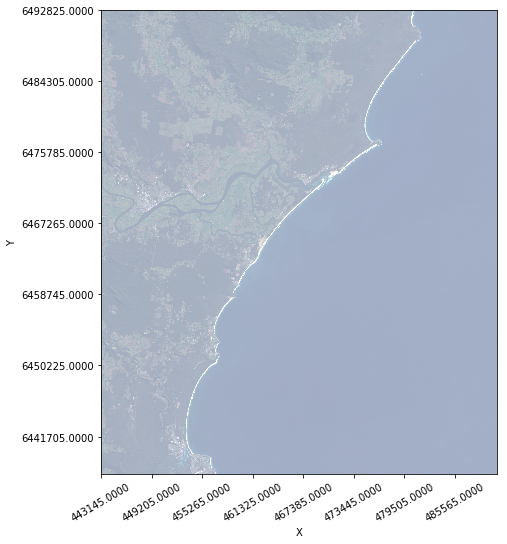

In [10]:
from utils.data_cube_utilities.dc_rgb import rgb
rgb(ds.isel(time=6), x_coord='x', y_coord='y')
plt.show()

## <span id="bathymetry">Calculate the Bathymetry and NDWI Indices</span>  [&#9652;](#top)
> * The bathymetry function is located at the top of this notebook.

In [11]:
# Create Bathemtry Index column
ds["bathymetry"] = bathymetry_index(ds)

In [12]:
from utils.data_cube_utilities.dc_water_classifier import NDWI
# (green - nir) / (green + nir)
ds["ndwi"] = NDWI(ds, band_pair=1)

<hr>

#### Preview Combined Dataset

In [13]:
ds

<xarray.Dataset>
Dimensions:     (time: 35, x: 1582, y: 1854)
Coordinates:
  * time        (time) datetime64[ns] 2017-03-05T23:43:08.071085 ...
  * y           (y) float64 6.493e+06 6.493e+06 6.493e+06 6.493e+06 ...
  * x           (x) float64 4.431e+05 4.432e+05 4.432e+05 4.432e+05 ...
Data variables:
    red         (time, y, x) int16 7409 7219 7057 6992 6681 7265 7716 7667 ...
    blue        (time, y, x) int16 9152 8963 8867 8880 8634 8994 9315 9425 ...
    green       (time, y, x) int16 8633 8379 8257 8171 7692 8250 8748 8765 ...
    nir         (time, y, x) int16 20952 18379 17023 15962 13921 16725 18606 ...
    quality     (time, y, x) int16 2720 2720 2720 2720 2720 2720 2720 2720 ...
    bathymetry  (time, y, x) float32 1.0064414 1.0074586 1.0079029 1.0092369 ...
    ndwi        (time, y, x) float64 -0.4164 -0.3737 -0.3468 -0.3228 -0.2882 ...
Attributes:
    crs:      EPSG:32756

## <span id="export_unmasked">Export Unmasked GeoTIFF</span>  [&#9652;](#top)

In [14]:
import os
from utils.data_cube_utilities.import_export import export_xarray_to_multiple_geotiffs

unmasked_dir = "geotiffs/landsat8/unmasked"
if not os.path.exists(unmasked_dir):
    os.makedirs(unmasked_dir)
export_xarray_to_multiple_geotiffs(ds, unmasked_dir + "/unmasked.tif",
                                   x_coord='x', y_coord='y')

## <span id="mask">Mask the Dataset Using the Quality Column and NDWI</span>  [&#9652;](#top)

In [15]:
# preview values
np.unique(ds["quality"])

array([2720, 2724, 2728, 2752, 2800, 2804, 2976, 3008, 3744, 3776, 6816,
       6848, 6896, 7072, 7104, 7840, 7872], dtype=int16)

#### Use NDWI to Mask Out Land
> The threshold can be tuned if need be to better fit the RGB image above. <br>
> Unfortunately our existing WOFS algorithm is designed to work with Surface Reflectance (SR) and does not work with this data yet but with a few modifications it could be made to do so.  We will approximate the WOFs mask with `NDWI` for now.

In [16]:
# Tunable threshold for masking the land out
threshold = .05

water = (ds.ndwi>threshold).values

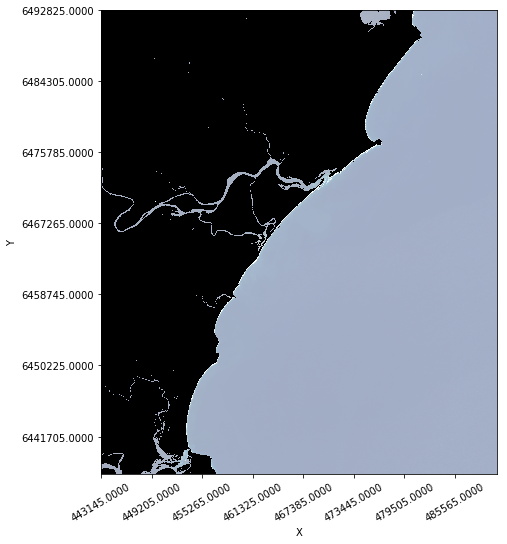

In [17]:
#preview one time slice to determine the effectiveness of the NDWI masking
rgb(ds.where(water).isel(time=6), x_coord='x', y_coord='y')
plt.show()

In [18]:
from utils.data_cube_utilities.dc_mosaic import ls8_oli_unpack_qa
clear_xarray  = ls8_oli_unpack_qa(ds.quality, "clear")

In [19]:
full_mask = np.logical_and(clear_xarray, water)

ds = ds.where(full_mask)

## <span id="vis_func">Create a Visualization Function</span>  [&#9652;](#top)

#### Visualize the distribution of the bathymetry index for the water pixels

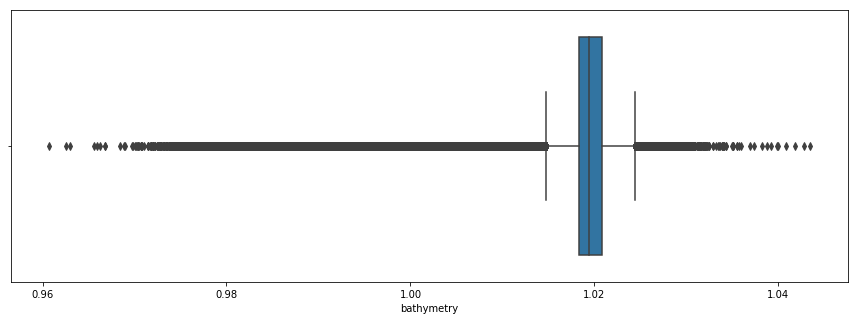

In [20]:
plt.figure(figsize=[15,5])

#Visualize the distribution of the remaining data
sns.boxplot(ds['bathymetry'])
plt.show()

> <b>Interpretation: </b> We can see that most of the values fall within a very short range.  We can scale our plot's cmap limits to fit the specific quantile ranges for the bathymetry index so we can achieve better contrast from our plots.

In [21]:
#set the quantile range in either direction from the median value
def get_quantile_range(col, quantile_range = .25):
    low = ds[col].quantile(.5 - quantile_range,["time","y","x"]).values
    high = ds[col].quantile(.5 + quantile_range,["time","y","x"]).values
    return low,high

In [22]:
#Custom function for a color mapping object
from matplotlib.colors import LinearSegmentedColormap

def custom_color_mapper(name = "custom", val_range = (1.96,1.96), colors = "RdGnBu"):
    custom_cmap = LinearSegmentedColormap.from_list(name,colors=colors)
    
    min, max = val_range
    step = max/10.0
    Z = [min,0],[0,max]
    levels = np.arange(min,max+step,step)
    cust_map = plt.contourf(Z, 100, cmap=custom_cmap)
    plt.clf()
    return cust_map.cmap

In [23]:
def mean_value_visual(ds, col, figsize = [15,15], cmap = "GnBu", low=None, high=None):
    if low is None: low = np.min(ds[col]).values
    if high is None: high = np.max(ds[col]).values
    ds.reduce(np.nanmean,dim=["time"])[col].plot.imshow(figsize = figsize, cmap=cmap,  
                                                        vmin=low, vmax=high)

## <span id="bath_vis">Visualize the Bathymetry</span>  [&#9652;](#top)

/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/xarray-0.10.8-py3.5.egg/xarray/core/variable.py:1264: RuntimeWarning: Mean of empty slice
  axis=axis, **kwargs)


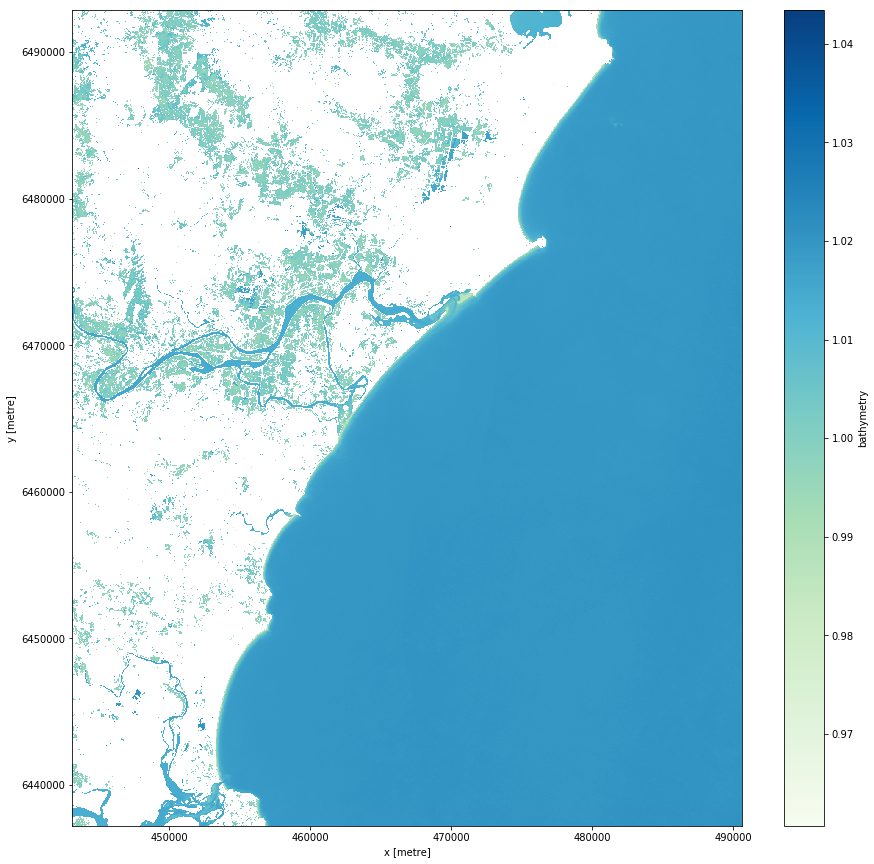

In [24]:
mean_value_visual(ds, "bathymetry", cmap="GnBu")

## <span id="bath_vis_better">Visualize the Bathymetry With Adjusted Contrast</span>  [&#9652;](#top)

> If we clamp the range of the plot using different quantile ranges we can see relative differences in higher contrast.

/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/xarray-0.10.8-py3.5.egg/xarray/core/variable.py:1264: RuntimeWarning: Mean of empty slice
  axis=axis, **kwargs)


<Figure size 432x288 with 0 Axes>

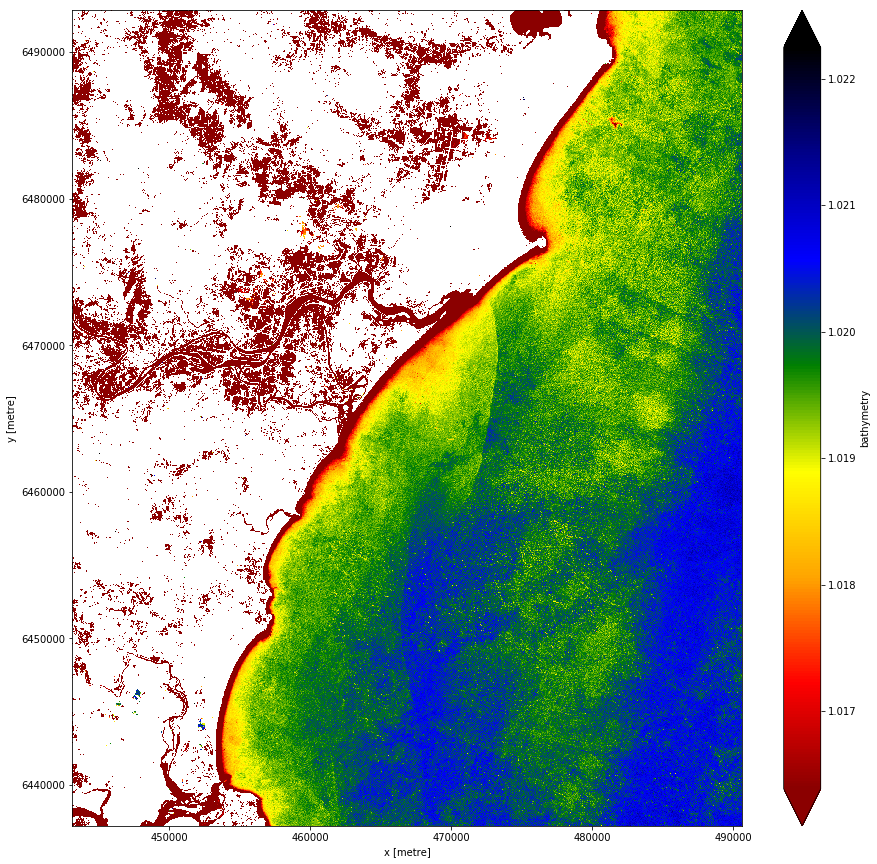

In [25]:
# create range using the 10th and 90th quantile
low, high = get_quantile_range("bathymetry", .40)


custom = custom_color_mapper(val_range=(low,high),
                             colors=["darkred","red","orange","yellow","green",
                                     "blue","darkblue","black"])

mean_value_visual(ds, "bathymetry", cmap=custom, low=low, high=high)

/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/xarray-0.10.8-py3.5.egg/xarray/core/variable.py:1264: RuntimeWarning: Mean of empty slice
  axis=axis, **kwargs)


<Figure size 432x288 with 0 Axes>

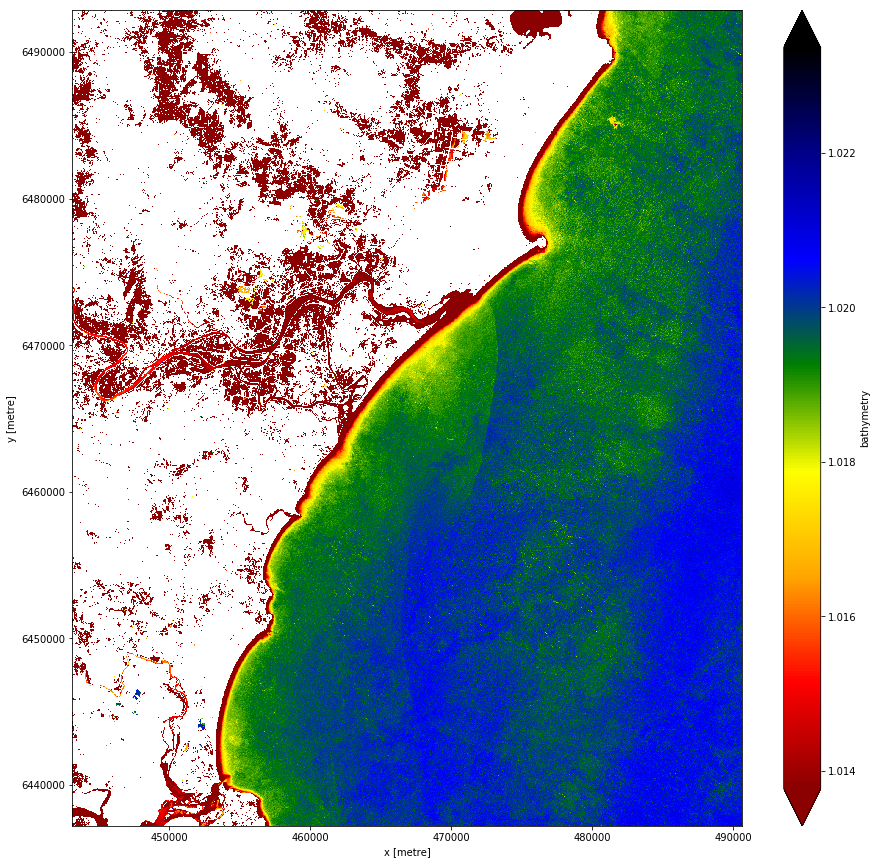

In [26]:
# create range using the 5th and 95th quantile
low, high = get_quantile_range("bathymetry", .45)


custom = custom_color_mapper(val_range=(low,high),
                             colors=["darkred","red","orange","yellow","green",
                                     "blue","darkblue","black"])

mean_value_visual(ds, "bathymetry", cmap = custom, low=low, high = high)

/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/xarray-0.10.8-py3.5.egg/xarray/core/variable.py:1264: RuntimeWarning: Mean of empty slice
  axis=axis, **kwargs)


<Figure size 432x288 with 0 Axes>

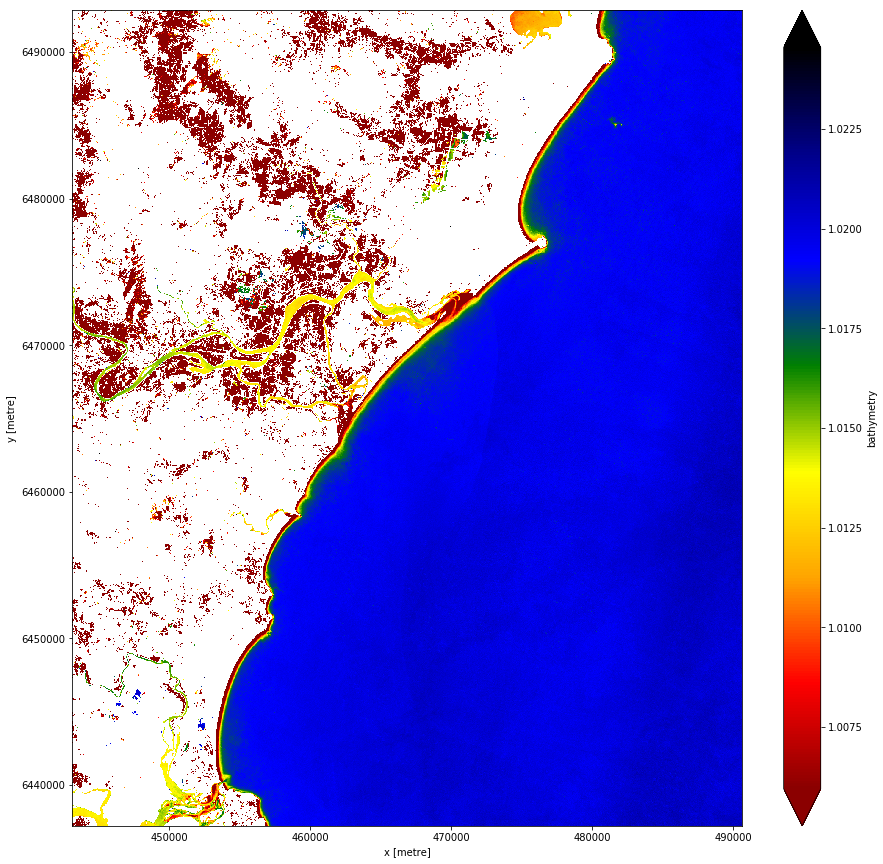

In [27]:
# create range using the 2nd and 98th quantile
low, high = get_quantile_range("bathymetry", .48)


custom = custom_color_mapper(val_range=(low,high),
                             colors=["darkred","red","orange","yellow","green",
                                     "blue","darkblue","black"])

mean_value_visual(ds, "bathymetry", cmap=custom, low=low, high=high)

/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/xarray-0.10.8-py3.5.egg/xarray/core/variable.py:1264: RuntimeWarning: Mean of empty slice
  axis=axis, **kwargs)


<Figure size 432x288 with 0 Axes>

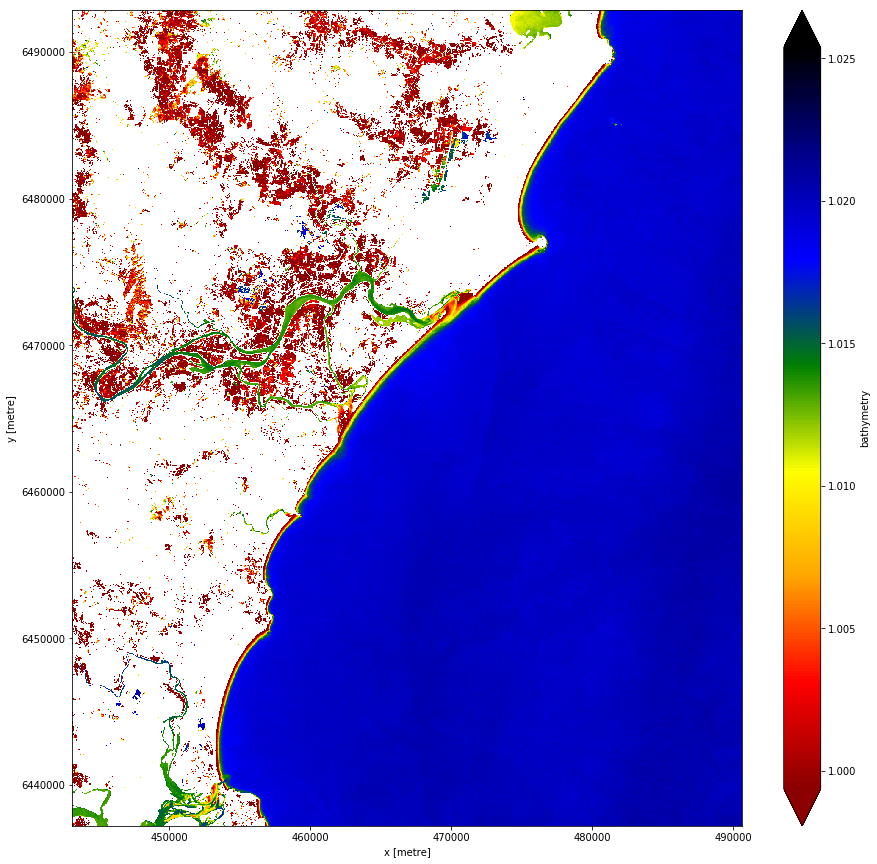

In [28]:
# create range using the 1st and 99th quantile
low, high = get_quantile_range("bathymetry", .49)


custom = custom_color_mapper(val_range=(low,high),
                             colors=["darkred","red","orange","yellow","green",
                                     "blue","darkblue","black"])

mean_value_visual(ds, "bathymetry", cmap=custom, low=low, high=high)

## <span id="export_masked">Export the Masked GeoTIFF</span>  [&#9652;](#top)

In [29]:
masked_dir = "geotiffs/landsat8/masked"
if not os.path.exists(masked_dir):
    os.makedirs(masked_dir)
export_xarray_to_geotiff(ds, masked_dir + "/masked.tif", 
                         x_coord='x', y_coord='y')